In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np 
import matplotlib.pyplot as plt 
import pandas 
import pydicom 
import os
import tensorflow_io as tfio
import tensorflow_addons as tfa
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Parse Data

In [3]:
dir = r"C:\Users\yunfe\Downloads\ISIC_DATA"

# Get all the training files
filenames = [os.path.join(dir, filename) for filename in os.listdir(dir) if filename.endswith(".tfrec") & filename.startswith("train")]

raw_dataset = tf.data.TFRecordDataset(filenames)
raw_dataset

for raw_record in raw_dataset.take(3):
  print(repr(raw_record))

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x95\x89\t\n\x13\n\npatient_id\x12\x05\x1a\x03\n\x01\x00\n\x0f\n\x06target\x12\x05\x1a\x03\n\x01\x00\n\x0f\n\x05width\x12\x06\x1a\x04\n\x02\xf0.\n\x0c\n\x03sex\x12\x05\x1a\x03\n\x01\x00\n\x10\n\x06height\x12\x06\x1a\x04\n\x02\xa0\x1f\n\x13\n\nage_approx\x12\x05\x1a\x03\n\x01-\n&\n\x1danatom_site_general_challenge\x12\x05\x1a\x03\n\x01\x00\n\x12\n\tdiagnosis\x12\x05\x1a\x03\n\x01\x00\n\x1e\n\nimage_name\x12\x10\n\x0e\n\x0cISIC_2637011\n\xc9\x87\t\n\x05image\x12\xbe\x87\t\n\xba\x87\t\n\xb6\x87\t\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n

Parse data

In [4]:
# feature = {
#       'image': _bytes_feature,
#       'image_name': _bytes_feature,
#       'patient_id': _int64_feature,
#       'sex': _int64_feature,
#       'age_approx': _int64_feature,
#       'anatom_site_general_challenge': _int64_feature,
#       'diagnosis': _int64_feature,
#       'target': _int64_feature,
#       'width': _int64_feature,
#       'height': _int64_feature
# }


# Create a description of the features.
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'patient_id': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'sex': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'age_approx': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'diagnosis': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'target': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'width': tf.io.FixedLenFeature([], tf.int64, default_value=0),
    'height': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, feature_description)


parsed_dataset = raw_dataset.map(_parse_function)
parsed_dataset


<MapDataset element_spec={'age_approx': TensorSpec(shape=(), dtype=tf.int64, name=None), 'anatom_site_general_challenge': TensorSpec(shape=(), dtype=tf.int64, name=None), 'diagnosis': TensorSpec(shape=(), dtype=tf.int64, name=None), 'height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image': TensorSpec(shape=(), dtype=tf.string, name=None), 'image_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'patient_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sex': TensorSpec(shape=(), dtype=tf.int64, name=None), 'target': TensorSpec(shape=(), dtype=tf.int64, name=None), 'width': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

Get the images and malignancy data

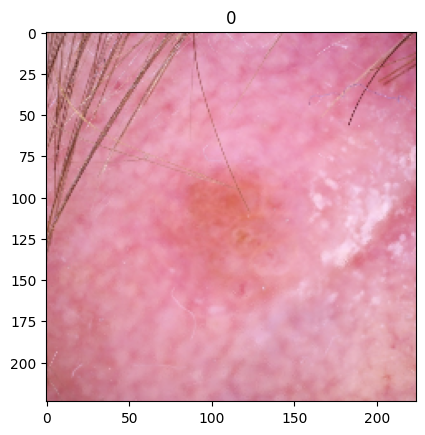

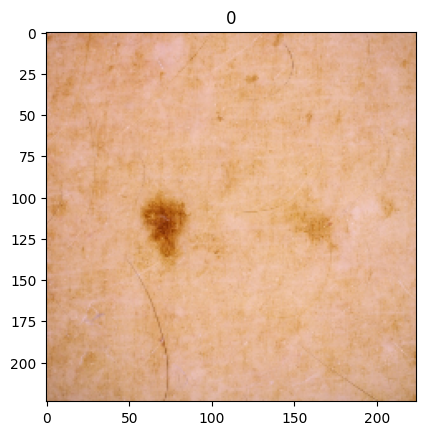

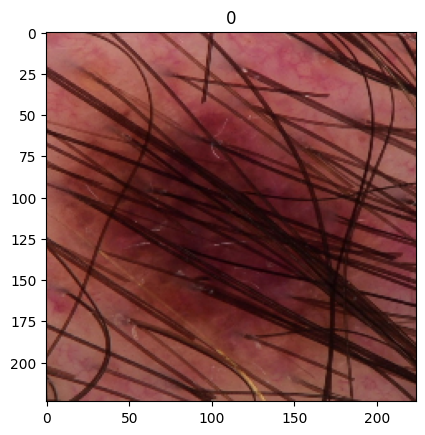

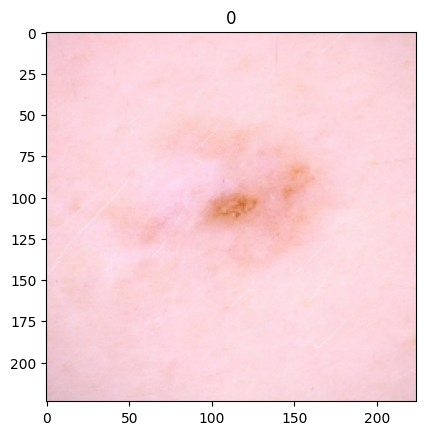

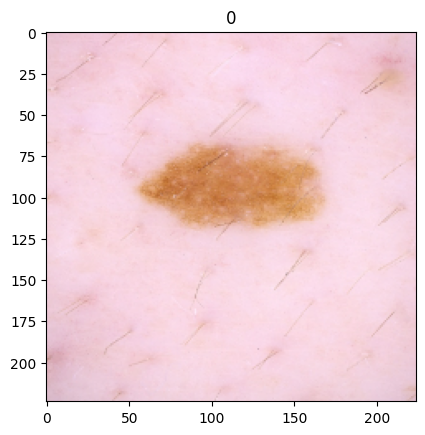

In [15]:
IMAGE_RESOLUTION = 224

def read_and_decode_image(image_raw):
    image = tf.image.decode_image(image_raw, channels=3)
    image = tf.image.resize(image, [IMAGE_RESOLUTION, IMAGE_RESOLUTION])
    # image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

def read_and_decode_tfr(dataset):
    def decode_image(image_raw):
        image = tf.py_function(read_and_decode_image, [image_raw], tf.uint8)
        image.set_shape(tf.TensorShape([IMAGE_RESOLUTION, IMAGE_RESOLUTION, 3]))
        return image
    
    def decode_target(target_raw):
        target = tf.py_function(lambda x: x.numpy(), [target_raw], tf.int64)
        target.set_shape(tf.TensorShape([]))
        return target
    
    target = decode_target(dataset['target'])

    image = decode_image(dataset['image'])
    return image, target

all_data = parsed_dataset.map(read_and_decode_tfr)

for image, target in all_data.take(5): 
    plt.imshow(image)
    plt.title(target.numpy())
    plt.show()
    

Create the model

In [26]:
batch_size = 32

all_data_batched = all_data.shuffle(buffer_size=1000).batch(batch_size)

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
    model.fit(all_data_batched, epochs=5)

Epoch 1/5
    908/Unknown - 414s 439ms/step - loss: 10.7880 - accuracy: 0.9747